In [1]:
# Sarah loves music

from carabao.neurotron import Pulse,Terminal,Synapses,toy
from carabao.util import repr
from carabao.screen import Screen
from numpy import array

#===================================================================================
# class: Core
#===================================================================================

class Core:
    """
    class Core: implements a Neurotron core functionality
    >>> core = Core(k,excite,predict,depress,(10,3))
    """
    def __init__(self,k, e,d,p, name=""):
        self.k = k
        self.name = name

        self.excite  = Terminal(e.w[k],e.theta,'excite')
        self.depress = Terminal(d.w[k],d.theta,'depress')
        self.predict = Terminal(p.W[k],p.theta,'predict')

    def __call__(self,f,c,V,log=None):
        e = self.excite.empower(f)
        u = self.excite.spike(e)
        if log is not None: 
            print("   ",log,self.name,"e:",repr(e), "u:",u)

        v = self.depress.empower(c)
        d = self.depress.spike(v) 
        if log is not None: 
            print("   ",log,self.name,"v:",repr(v), "d:",d)

        E = self.predict.empower(V)
        s = self.predict.spike(E)
        if log is not None: 
            print("   ",log,self.name,"E:",repr(E), "s:",repr(s))

    def __repr__(self):
        return "Core('%s',%g"% (self.name,self.k) + ")"
        
#===================================================================================
# class: Neurotron
#===================================================================================

class Neurotron:
    """
    class Neurotron: full functionality
    >>> par = toy('sarah')
    >>> cell0 = Neurotron(k:=0,par,(10,3),'cell0')
    >>> print(cell0)
    """
    def __init__(self,k,par,partition,name=None):
        self.k = k
        self.partition = partition
        self.name = name
        
        self.u = Pulse(1,1)
        self.p = 0
        self.d = Pulse(2,3)
        self.y = 0
        
        epar,dpar,ppar = par

        self.excite  = Terminal(epar.w[k],epar.theta,'excite')
        self.excite.synapses = Synapses(epar.k[k],epar.p[k],epar.eta)

        self.depress = Terminal(dpar.w[k],dpar.theta,'depress')
        self.depress.synapses = Synapses(dpar.g[k],dpar.p[k],dpar.eta)
    
        self.predict = Terminal(ppar.W[k],ppar.theta,'predict')
        self.predict.synapses = Synapses(ppar.K[k],ppar.P[k],ppar.eta)

    def __call__(self,y,log=None):
        nc,nf = self.partition; k = self.k
        c = y[:nc];  f = y[nc:nc+nf]
        
        if log is not None:
           print("f:",f,", c:",c)
            
        u = self.excite(f,"=> excite-%g" % k)[0]
        self.u(u,' - u%g:' % k)
        
        d = self.depress(c,"=> depress-%g" % k)[0]
        self.d(d,' - d%g:' % k)
        
        self.s = self.predict(c,"=> predict-%g" % k)
        #b = self.s.max()

        return y

    def __repr__(self):
        #state = "), <updy> = <%g%g%g%g>" % (self.u,self.p,self.d,self.y)
        return "Neurotron('%s',%g"% (self.name,self.k) + ""

#===========================================================================
# class Moni
#===========================================================================

class Moni:
    def __init__(self,m,n):
        self.screen = Screen('Neurons',m,n)
    def __call__(self,cell,i,j):
        self.screen.neurotron((i,j),1,1,1,1,1)

#===========================================================================
# class Cells
#===========================================================================

class Cells:
    def __init__(self,n,par,partition):
        self.cells = []
        for k in range(n):
            cell = Neurotron(k,par,partition)
            self.cells.append(cell)

    def __call__(self,y,log=None):
        for k in range(len(self.cells)):
            y = self.cells[k](y,log)
        return y

    def __getitem__(self,k):
        return self.cells[k]




f: [1, 1, 1, 0, 1, 0, 1, 1, 1, 1] , c: [1, 1, 0]
=> excite-0 [1 1 1 0 1 0 1 1 1 1] -> #[1 1 0 1 1 1 0 1 0 1] -> #[1 1 0 0 1 0 0 1 0 1] -> :[0]
 - u0:  0 -> ([0,0],0/1) -> 0
=> depress-0 [1 1 0] -> #[1 1 1] -> #[1 1 0] -> :[1]
 - d0:  1 -> ([1,0,0],0/3) -> 0
=> predict-0 [1 1 0] -> #[1 0 0; 1 0 0] -> #[1 0 0; 1 0 0] -> :[0 0]
f: [1, 1, 1, 0, 1, 0, 1, 1, 1, 1] , c: [1, 1, 0]
=> excite-1 [1 1 1 0 1 0 1 1 1 1] -> #[0 1 1 1 0 1 1 0 1 1] -> #[0 1 1 0 0 0 1 0 1 1] -> :[0]
 - u1:  0 -> ([0,0],0/1) -> 0
=> depress-1 [1 1 0] -> #[1 1 1] -> #[1 1 0] -> :[1]
 - d1:  1 -> ([1,0,0],0/3) -> 0
=> predict-1 [1 1 0] -> #[1 0 0; 1 0 0] -> #[1 0 0; 1 0 0] -> :[0 0]
f: [1, 1, 1, 0, 1, 0, 1, 1, 1, 1] , c: [1, 1, 0]
=> excite-2 [1 1 1 0 1 0 1 1 1 1] -> #[1 1 1 0 0 1 0 1 1 1] -> #[1 1 1 0 0 0 0 1 1 1] -> :[1]
 - u2:  1 -> ([1,0],0/1) -> 0
=> depress-2 [1 1 0] -> #[1 1 1] -> #[1 1 0] -> :[1]
 - d2:  1 -> ([1,0,0],0/3) -> 0
=> predict-2 [1 1 0] -> #[1 0 0; 1 0 0] -> #[1 0 0; 1 0 0] -> :[0 0]


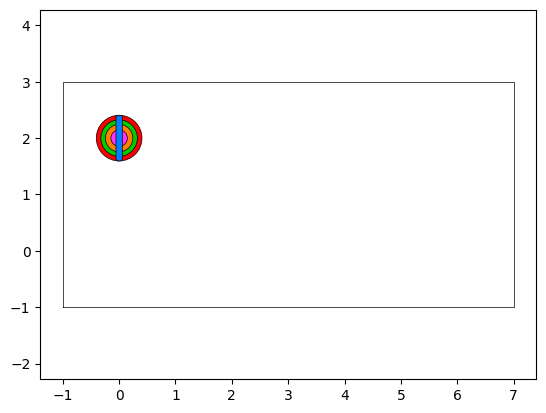

In [2]:
f = [1,1,0,1,1,1,0,1,0,1];  c = [1,1,1]; y = f+c
par,token = toy('sarah')
cells = Cells(3,par,(len(c),len(f)))

mon = Moni(3,7)
y = cells(y,'run')
#cells.plot(0)
mon(cells[0],0,0)

In [3]:
#=========================================================================
# Sarah Loves music
#=========================================================================

f = [1,1,0,1,1,1,0,1,0,1];  c = [1,1,1]; x = f+c
par,token = toy('sarah')
cell = Neurotron(0,par,(len(f),len(c)),'cell0') 

print(cell.excite)

E = cell.excite(token['Sarah'],"decode 'Sarah':")
E = cell.excite(token['loves'],"decode 'loves':")
E = cell.excite(token['music'],"decode 'music':")

# or broken down to the intermediate steps:

E = cell.excite.empower(token['Sarah'],"empower 'Sarah':")
s = cell.excite.spike(E,'         spike:')

E = cell.excite.empower(token['loves'],"empower 'loves':")
s = cell.excite.spike(E,'         spike:')


Terminal('excite',#[1 1 0 1 1 1 0 1 0 1],6) @ {#[0 1 2 3 4 5 6 7 8 9], #[1 1 0 1 1 1 0 1 0 1] @ 0.5}
decode 'Sarah': [1 1 0 1 1 1 0 1 0 1] -> #[1 1 0 1 1 1 0 1 0 1] -> #[1 1 0 1 1 1 0 1 0 1] -> :[1]
decode 'loves': [0 1 1 1 0 1 1 0 1 1] -> #[1 1 0 1 1 1 0 1 0 1] -> #[0 1 0 1 0 1 0 0 0 1] -> :[0]
decode 'music': [1 1 1 0 0 1 0 1 1 1] -> #[1 1 0 1 1 1 0 1 0 1] -> #[1 1 0 0 0 1 0 1 0 1] -> :[0]
empower 'Sarah': [1 1 0 1 1 1 0 1 0 1] -> #[1 1 0 1 1 1 0 1 0 1]
         spike: #[1 1 0 1 1 1 0 1 0 1] -> :[1]
empower 'loves': [0 1 1 1 0 1 1 0 1 1] -> #[0 1 0 1 0 1 0 0 0 1]
         spike: #[0 1 0 1 0 1 0 0 0 1] -> :[0]


In [4]:
#=========================================================================
# iterations on top level
#=========================================================================

par,token = toy('sarah')
c = [1,1,1];  f = token['Sarah'];  y = c + f
cell = [None,None,None]

cell[0] = Neurotron(0,par,(len(f),len(c)),'cell0') 
cell[1] = Neurotron(1,par,(len(f),len(c)),'cell1') 
cell[2] = Neurotron(2,par,(len(f),len(c)),'cell2') 

print("\nIteration 1: apply y := [1,1,1] + token['Sarah']")
y = cell[0](y,'apply')
y = cell[1](y,'apply')
y = cell[2](y,'apply')

print("\nIteration 2: apply y := [1,1,1] + token['Sarah']")
y = cell[0](y,'apply')
y


Iteration 1: apply y := [1,1,1] + token['Sarah']
f: [1, 0, 1] , c: [1, 1, 1, 1, 1, 0, 1, 1, 1, 0]


ValueError: operands could not be broadcast together with shapes (1,10) (3,) 